##### Objectives
Creating Several Machine Learning models for the predictions of energy generated by a wind turbine system, given the weather conditions an hour prior

##### 1. Data loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"C:\Users\Abdulwahab\Desktop\Amdari Projects\2. Renewable Energy Forecasting with Pandas and Machie Learning\TexasTurbine.csv")
df.head()

,Time stamp,System power generated | (kW),Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air temperature | ('C)
0,"Jan 1, 12:00 am",1766.64,9.926,128,1.000480,18.263
1,"Jan 1, 01:00 am",1433.83,9.273,135,0.999790,18.363
2,"Jan 1, 02:00 am",1167.23,8.660,142,0.999592,18.663
3,"Jan 1, 03:00 am",1524.59,9.461,148,0.998309,18.763
4,"Jan 1, 04:00 am",1384.28,9.184,150,0.998507,18.963


In [3]:
df.columns

Index(['Time stamp', 'System power generated | (kW)', 'Wind speed | (m/s)',
       'Wind direction | (deg)', 'Pressure | (atm)', 'Air temperature | ('C)'],
      dtype='object')

In [4]:
df.shape

(8760, 6)

##### 2. Data Cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Time stamp                     8760 non-null   object 
 1   System power generated | (kW)  8760 non-null   float64
 2   Wind speed | (m/s)             8760 non-null   float64
 3   Wind direction | (deg)         8760 non-null   int64  
 4   Pressure | (atm)               8760 non-null   float64
 5   Air temperature | ('C)         8760 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 410.8+ KB


In [6]:
# Checking for missing values
df.isna().sum()

Time stamp                       0
System power generated | (kW)    0
Wind speed | (m/s)               0
Wind direction | (deg)           0
Pressure | (atm)                 0
Air temperature | ('C)           0
dtype: int64

In [7]:
# Change the format of the Time stamp (mon  day, hour:min am/pm) to our desire format (Year-month-day hour:min:sec)
pd.to_datetime(df["Time stamp"], format = '%b %d, %I:%M %p').dt.strftime('%Y-%m-%d %H:%M:%S')

0       1900-01-01 00:00:00
1       1900-01-01 01:00:00
2       1900-01-01 02:00:00
3       1900-01-01 03:00:00
4       1900-01-01 04:00:00
               ...         
8755    1900-12-31 19:00:00
8756    1900-12-31 20:00:00
8757    1900-12-31 21:00:00
8758    1900-12-31 22:00:00
8759    1900-12-31 23:00:00
Name: Time stamp, Length: 8760, dtype: object

In [8]:
# Fix the timestamp to it correct datatype
df['Time stamp'] = pd.to_datetime(df["Time stamp"], format = '%b %d, %I:%M %p').dt.strftime('%Y-%m-%d %H:%M:%S')

# Replace the !900 with 2021
df['Time stamp'] = df['Time stamp'].str.replace('1900', '2021')

# Convert the timestamp to it correct datatype
df['Time stamp'] = pd.to_datetime(df["Time stamp"])

In [9]:
df['Time stamp']

0      2021-01-01 00:00:00
1      2021-01-01 01:00:00
2      2021-01-01 02:00:00
3      2021-01-01 03:00:00
4      2021-01-01 04:00:00
               ...        
8755   2021-12-31 19:00:00
8756   2021-12-31 20:00:00
8757   2021-12-31 21:00:00
8758   2021-12-31 22:00:00
8759   2021-12-31 23:00:00
Name: Time stamp, Length: 8760, dtype: datetime64[ns]

In [10]:
# Set the timestamp as index
df.index = df['Time stamp']

# Drop the time stamp column to avoid duplicate column of the time stamp since we already made it our index
df.drop('Time stamp', axis = 1, inplace = True)

In [11]:
df.head()

,System power generated | (kW),Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air temperature | ('C)
Time stamp,,,,,
2021-01-01 00:00:00,1766.64,9.926,128,1.000480,18.263
2021-01-01 01:00:00,1433.83,9.273,135,0.999790,18.363
2021-01-01 02:00:00,1167.23,8.660,142,0.999592,18.663
2021-01-01 03:00:00,1524.59,9.461,148,0.998309,18.763
2021-01-01 04:00:00,1384.28,9.184,150,0.998507,18.963


In [12]:
# Check for duplicates
df.duplicated().sum()

0

##### 3. Feature Engineering

In [13]:
# Extract the following from the date index: day of the week, week, month, quarter
def extract_features(dataframe):
    '''
    this function extract data feature from index and create a saeson column
    '''
    # copy df1
    dataframe["year"] = dataframe.index.year
    dataframe["month"] = dataframe.index.month
    dataframe["quarter"] = dataframe.index.quarter
    dataframe["week"] = dataframe.index.isocalendar().week.astype(int)
    dataframe["day"] = dataframe.index.day
    dataframe["hour"] = dataframe.index.hour

    return dataframe



# Group your months into season

def group_month_into_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'winter'

In [14]:
# Save this as your new dataframe
df = extract_features(df)

In [15]:
# Apply function to the data

df['Season'] = df['month'].apply(group_month_into_season)

In [16]:
df.head()

,System power generated | (kW),Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air temperature | ('C),year,month,quarter,week,day,hour,Season
Time stamp,,,,,,,,,,,,
2021-01-01 00:00:00,1766.64,9.926,128,1.000480,18.263,2021,1,1,53,1,0,winter
2021-01-01 01:00:00,1433.83,9.273,135,0.999790,18.363,2021,1,1,53,1,1,winter
2021-01-01 02:00:00,1167.23,8.660,142,0.999592,18.663,2021,1,1,53,1,2,winter
2021-01-01 03:00:00,1524.59,9.461,148,0.998309,18.763,2021,1,1,53,1,3,winter
2021-01-01 04:00:00,1384.28,9.184,150,0.998507,18.963,2021,1,1,53,1,4,winter


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2021-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   System power generated | (kW)  8760 non-null   float64
 1   Wind speed | (m/s)             8760 non-null   float64
 2   Wind direction | (deg)         8760 non-null   int64  
 3   Pressure | (atm)               8760 non-null   float64
 4   Air temperature | ('C)         8760 non-null   float64
 5   year                           8760 non-null   int32  
 6   month                          8760 non-null   int32  
 7   quarter                        8760 non-null   int32  
 8   week                           8760 non-null   int32  
 9   day                            8760 non-null   int32  
 10  hour                           8760 non-null   int32  
 11  Season                         8760 non-null   object 
dtypes: float64(4

In [18]:
df.columns

Index(['System power generated | (kW)', 'Wind speed | (m/s)',
       'Wind direction | (deg)', 'Pressure | (atm)', 'Air temperature | ('C)',
       'year', 'month', 'quarter', 'week', 'day', 'hour', 'Season'],
      dtype='object')

In [19]:
# Rename the columns

df.columns = ['power_generated', 'wind_speed', 'wind_direction','pressure', 'temperature',
               'year', 'month', 'quarter', 'week', 'day', 'hour',  'Season']

In [20]:
df.head()

,power_generated,wind_speed,wind_direction,pressure,temperature,year,month,quarter,week,day,hour,Season
Time stamp,,,,,,,,,,,,
2021-01-01 00:00:00,1766.64,9.926,128,1.000480,18.263,2021,1,1,53,1,0,winter
2021-01-01 01:00:00,1433.83,9.273,135,0.999790,18.363,2021,1,1,53,1,1,winter
2021-01-01 02:00:00,1167.23,8.660,142,0.999592,18.663,2021,1,1,53,1,2,winter
2021-01-01 03:00:00,1524.59,9.461,148,0.998309,18.763,2021,1,1,53,1,3,winter
2021-01-01 04:00:00,1384.28,9.184,150,0.998507,18.963,2021,1,1,53,1,4,winter


### Exploratory Data Analysis (EDA)

##### Univariate Analysis : power_generated, wind_speed, wind_direction, pressure, temperature, and season

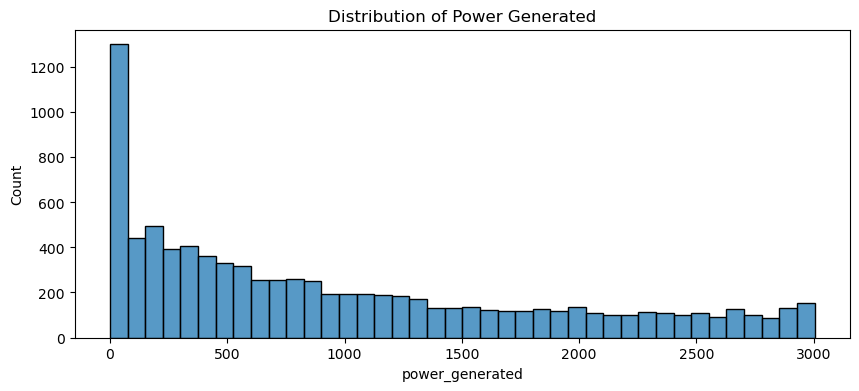

In [21]:
plt.figure(figsize = (10,4))
sns.histplot(df['power_generated'], bins = 40)
plt.title('Distribution of Power Generated');

##### **Observations**
- There are quite alot of Zero(0) power genrated i.e no power was generated.

In [22]:
# statistical description of power_generated
df.power_generated.describe()

count    8760.000000
mean      964.467934
std       878.558112
min         0.000000
25%       215.951500
50%       693.968500
75%      1562.287500
max      3004.010000
Name: power_generated, dtype: float64

In [23]:
# Investigating why some of the power generated are zeros(0)

df[df['power_generated'] <= 0]

,power_generated,wind_speed,wind_direction,pressure,temperature,year,month,quarter,week,day,hour,Season
Time stamp,,,,,,,,,,,,
2021-01-05 00:00:00,0.0,2.491,156,0.991694,20.263,2021,1,1,1,5,0,winter
2021-01-05 01:00:00,0.0,0.484,95,0.994162,19.963,2021,1,1,1,5,1,winter
2021-01-07 22:00:00,0.0,2.788,340,1.002560,10.863,2021,1,1,1,7,22,winter
2021-01-07 23:00:00,0.0,2.116,273,1.001870,11.963,2021,1,1,1,7,23,winter
2021-01-08 00:00:00,0.0,2.897,284,1.000980,12.063,2021,1,1,1,8,0,winter
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27 23:00:00,0.0,2.748,241,0.997129,13.863,2021,12,4,52,27,23,winter
2021-12-28 00:00:00,0.0,2.135,271,0.996338,14.163,2021,12,4,52,28,0,winter
2021-12-28 01:00:00,0.0,2.076,246,0.996338,14.163,2021,12,4,52,28,1,winter


##### **Observations**
- we have 822 where power_generated was zeros

In [24]:
# Checking the day & time in which power_generated is zero
df.index[df['power_generated'] <= 0]

DatetimeIndex(['2021-01-05 00:00:00', '2021-01-05 01:00:00',
               '2021-01-07 22:00:00', '2021-01-07 23:00:00',
               '2021-01-08 00:00:00', '2021-01-08 01:00:00',
               '2021-01-08 10:00:00', '2021-01-08 11:00:00',
               '2021-01-08 15:00:00', '2021-01-08 16:00:00',
               ...
               '2021-12-25 08:00:00', '2021-12-25 09:00:00',
               '2021-12-25 10:00:00', '2021-12-26 05:00:00',
               '2021-12-27 22:00:00', '2021-12-27 23:00:00',
               '2021-12-28 00:00:00', '2021-12-28 01:00:00',
               '2021-12-28 02:00:00', '2021-12-30 03:00:00'],
              dtype='datetime64[ns]', name='Time stamp', length=822, freq=None)

In [25]:
df.index[df['power_generated'] <= 0][0:100]

DatetimeIndex(['2021-01-05 00:00:00', '2021-01-05 01:00:00',
               '2021-01-07 22:00:00', '2021-01-07 23:00:00',
               '2021-01-08 00:00:00', '2021-01-08 01:00:00',
               '2021-01-08 10:00:00', '2021-01-08 11:00:00',
               '2021-01-08 15:00:00', '2021-01-08 16:00:00',
               '2021-01-08 17:00:00', '2021-01-08 18:00:00',
               '2021-01-08 19:00:00', '2021-01-08 20:00:00',
               '2021-01-08 21:00:00', '2021-01-08 22:00:00',
               '2021-01-08 23:00:00', '2021-01-09 00:00:00',
               '2021-01-09 01:00:00', '2021-01-09 02:00:00',
               '2021-01-09 03:00:00', '2021-01-11 07:00:00',
               '2021-01-11 08:00:00', '2021-01-11 09:00:00',
               '2021-01-11 10:00:00', '2021-01-13 10:00:00',
               '2021-01-13 11:00:00', '2021-01-13 12:00:00',
               '2021-01-13 13:00:00', '2021-01-19 16:00:00',
               '2021-01-19 17:00:00', '2021-01-19 18:00:00',
               '2021-01-

In [26]:
# Checking the unique season in which power_generated is zero
df[df['power_generated'] <= 0]['Season'].unique()

array(['winter', 'Spring', 'Summer', 'Fall'], dtype=object)

In [27]:
# Checking the season value_counts in which power_generated is zero

df[df['power_generated'] <= 0]['Season'].value_counts()

Season
Fall      284
winter    239
Summer    191
Spring    108
Name: count, dtype: int64

##### **Observations**
- Fall season has the most zero power genreated followed by winter. 

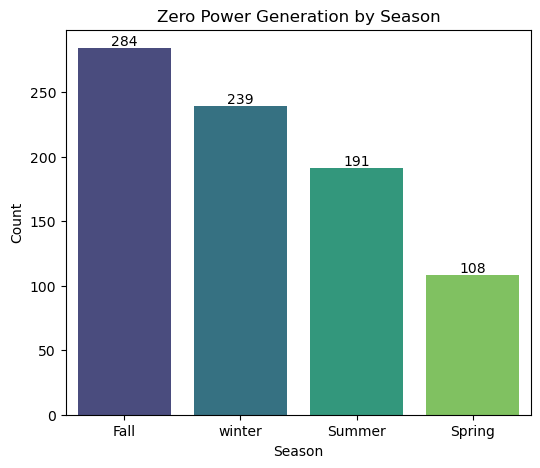

In [28]:
# To visualize the season where power generated is zero

season_count = df[df['power_generated'] <= 0]['Season'].value_counts()

plt.figure(figsize=(6,5))
ax = sns.barplot(x = season_count.index, y = season_count, palette = 'viridis')
ax.bar_label(ax.containers[0]) 

plt.title('Zero Power Generation by Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.show()

count    8760.000000
mean      964.467934
std       878.558112
min         0.000000
25%       215.951500
50%       693.968500
75%      1562.287500
max      3004.010000
Name: power_generated, dtype: float64


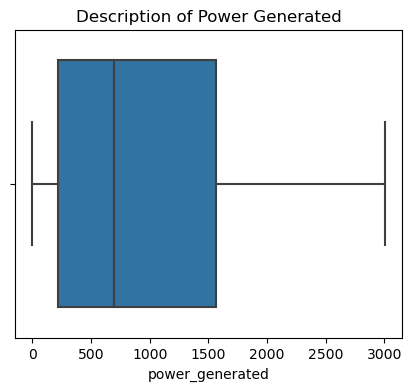

In [29]:
# checking statistical description of power and outliers in the Zero Power Generation by Season
pow_gen_des = df.power_generated.describe()

# box plot
plt.figure(figsize=(5,4))                 
sns.boxplot(x = df['power_generated'])
plt.title('Description of Power Generated')

print(pow_gen_des);

##### **Observations**
- There are no outliers for power generated

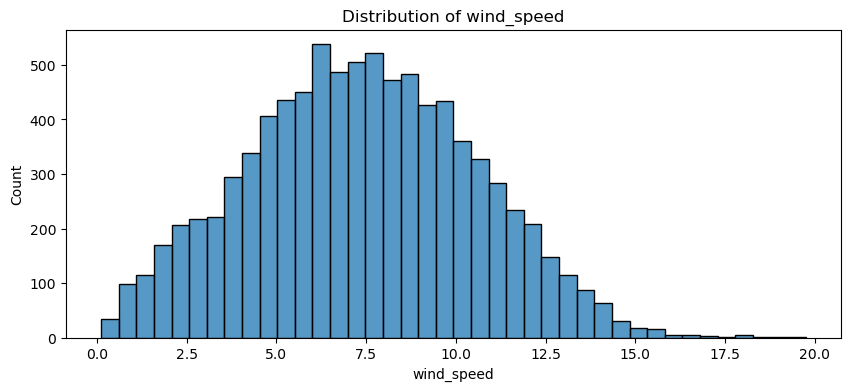

In [30]:
# Distribution of wind speed

plt.figure(figsize=(10,4))                 
sns.histplot(x = df['wind_speed'], bins = 40)
plt.title('Distribution of wind_speed');

##### **Observation**
- Wind speed is normally distributed.

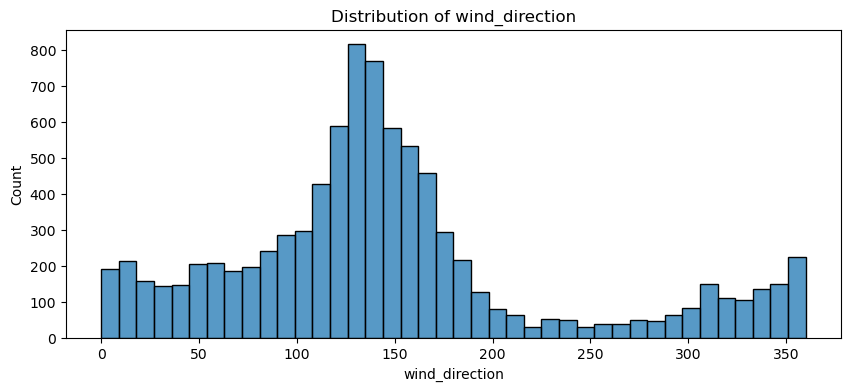

In [31]:
# Distribution of wind_direction

plt.figure(figsize=(10,4))                 
sns.histplot(x = df['wind_direction'], bins = 40)
plt.title('Distribution of wind_direction');

#### **Observation**
- Distribution of wind direction(in angles) is not strictly normal. It has sevaral peaks around (10, 50, 130, 360)mark and the Larger central of tendency fall around 130.
- Most of the Wind blowing the turbine system came from angles (110-170)

count    8760.000000
mean      146.616210
std        84.678754
min         0.000000
25%        99.000000
50%       135.000000
75%       169.000000
max       360.000000
Name: wind_direction, dtype: float64


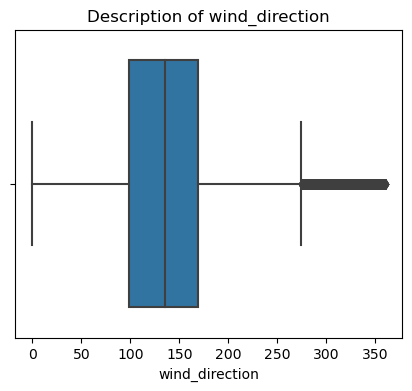

In [32]:
# checking statistical description of wind_direction and outliers
wind_dir_des = df.wind_direction.describe()

# box plot
plt.figure(figsize=(5,4))                 
sns.boxplot(x = df['wind_direction'])
plt.title('Description of wind_direction')

print(wind_dir_des);

##### **Observation**
- Severity of the outlier won't be much because of the continuity(closeness) of the values of the outliers

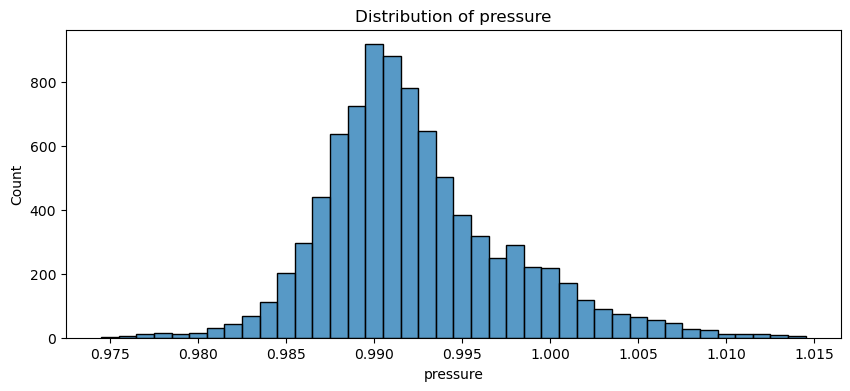

In [33]:
# Distribution of pressure

plt.figure(figsize=(10,4))                 
sns.histplot(x = df['pressure'], bins = 40)
plt.title('Distribution of pressure');

##### **Observation**
- Most of the pressure acting on the turbine system are btw (0.987 - 0.994)atm
- pressure is normally distributed.     

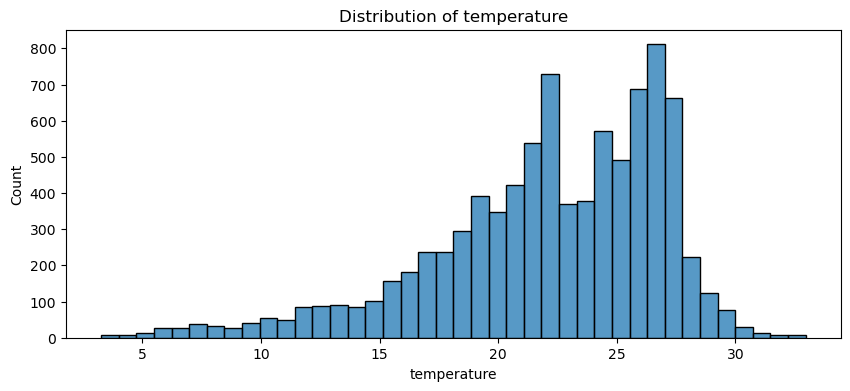

In [34]:
# Distribution of temperature

plt.figure(figsize=(10,4))                 
sns.histplot(x = df['temperature'], bins = 40) 
plt.title('Distribution of temperature');

##### Observation
Temperature is left skewed probably due to fact that there are more warm days than cold days

count    8760.000000
mean       22.147298
std         4.855232
min         3.263000
25%        19.463000
50%        22.763000
75%        26.063000
max        32.963000
Name: temperature, dtype: float64


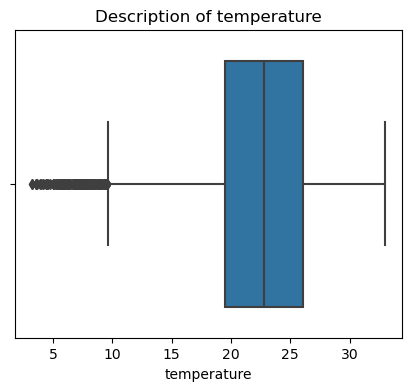

In [35]:
# checking statistical description of temperature and outliers
temp_des = df.temperature.describe()

# box plot
plt.figure(figsize=(5,4))                 
sns.boxplot(x = df['temperature'])
plt.title('Description of temperature')

print(temp_des);

##### **Observation**
- Temperature is skewed to the right probably due to the fact that there are more warm days than cold days

### Multivariate Analysis

##### power_generated, wind_speed, wind_direction, pressure, temperature, and season

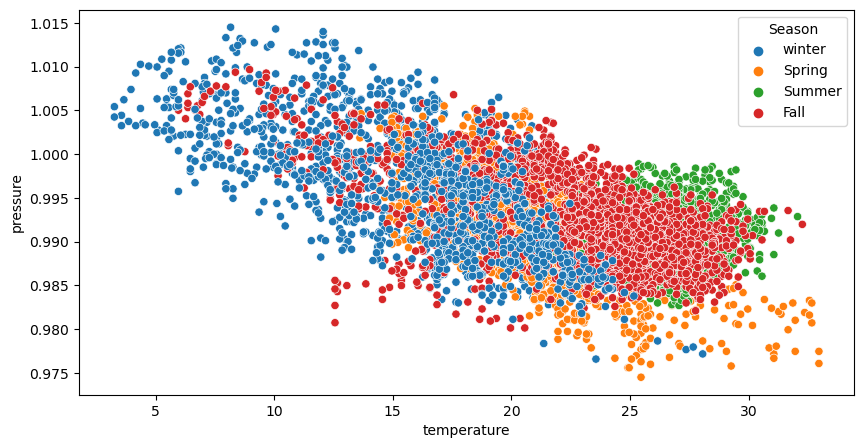

In [36]:
plt.figure(figsize=(10,5))
sns.scatterplot(x = 'temperature', y = 'pressure', data = df, hue = 'Season');

##### **Observations**
- winter: colder days(lower temp less than 20)
- Higher temp at low pressure, and low temp at higher pressure
- Summer: higher temp
- Fall: wilder range of temp & pressure

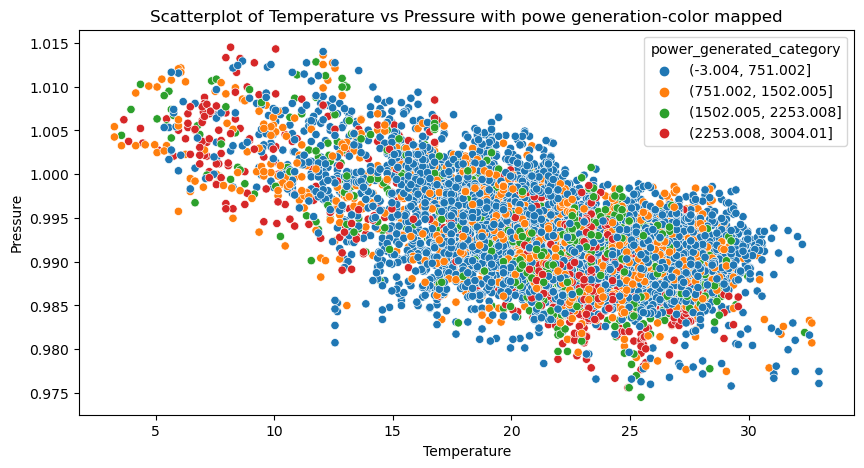

In [37]:
# Create bins of power generated values
num_bins = 4
bin_data = pd.cut(df['power_generated'], bins = num_bins)

# Visualization
plt.figure(figsize=(10,5))
sns.scatterplot(x = 'temperature', y = 'pressure', data = df, hue = bin_data, cmap = 'coolwarm')


plt.title('Scatterplot of Temperature vs Pressure with powe generation-color mapped')
plt.xlabel('Temperature')
plt.ylabel('Pressure')
plt.legend(title = 'power_generated_category', loc = 'upper right')


plt.show()

##### **Observations**
- Majority of the power generated is btw (0 - 751)

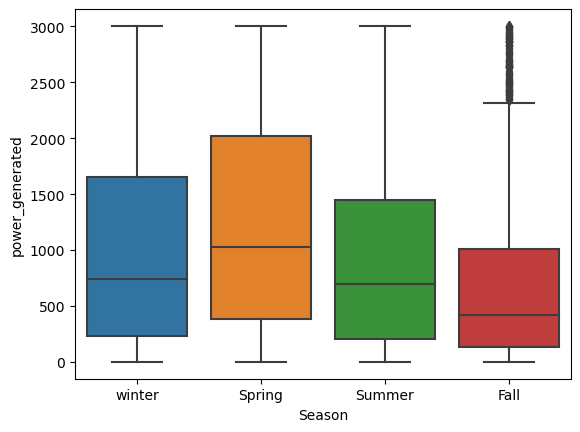

In [38]:
# Effect of season on power generated

sns.boxplot(x = 'Season', y = 'power_generated', data = df);

##### **Observation**
- Season with the most productive power generation is Spring and then fall comes last

In [39]:
a1 = df[['power_generated', 'Season']][df['Season'] == 'Fall'].describe()
a2 = df[['power_generated', 'Season']][df['Season'] == 'winter'].describe()

print(a1, a2)

       power_generated
count      2184.000000
mean        697.639070
std         753.499012
min           0.000000
25%         130.765250
50%         420.436500
75%        1005.512500
max        3004.010000        power_generated
count      2160.000000
mean       1008.864842
std         905.820733
min           0.000000
25%         230.332000
50%         737.539000
75%        1651.675000
max        3004.010000


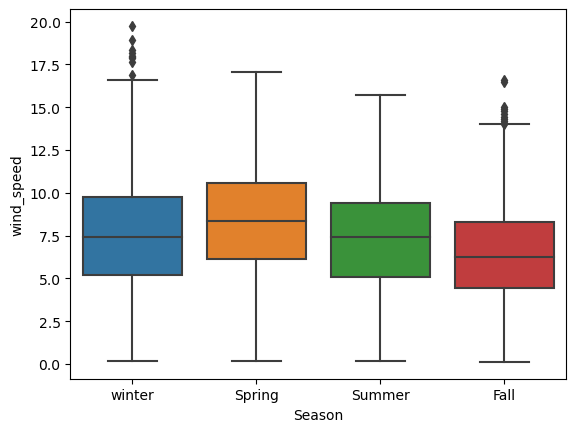

In [40]:
# Effect of season on power generated

sns.boxplot(x = 'Season', y = 'wind_speed', data = df);

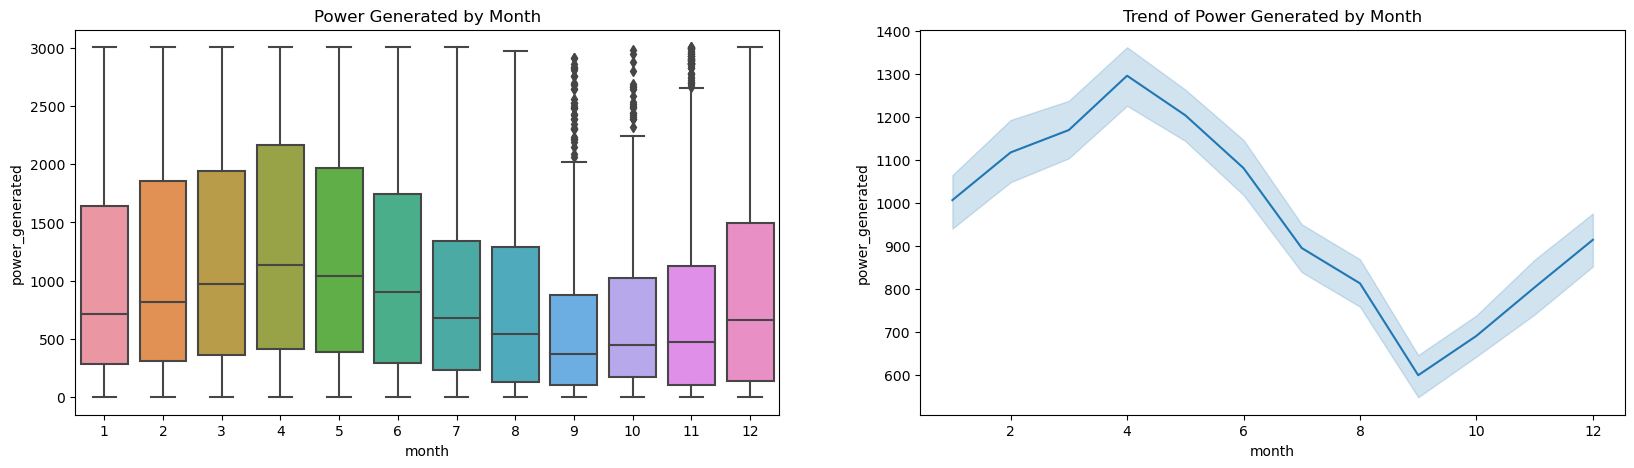

In [41]:
# month and power generated
fig, ax = plt.subplots(1,2, figsize = (20,5))

sns.boxplot(x = 'month', y = 'power_generated', data = df, ax = ax[0])
ax[0].set_title('Power Generated by Month')

sns.lineplot(x = 'month', y = 'power_generated', data = df, ax = ax[1])
ax[1].set_title('Trend of Power Generated by Month');

##### **Observations**
- There is a cyclical pattern that emerges (like a sine wave)
- Month 4 which fall within Spring season has the peak power generation while month 9 which comes under Fall has the lest power generation

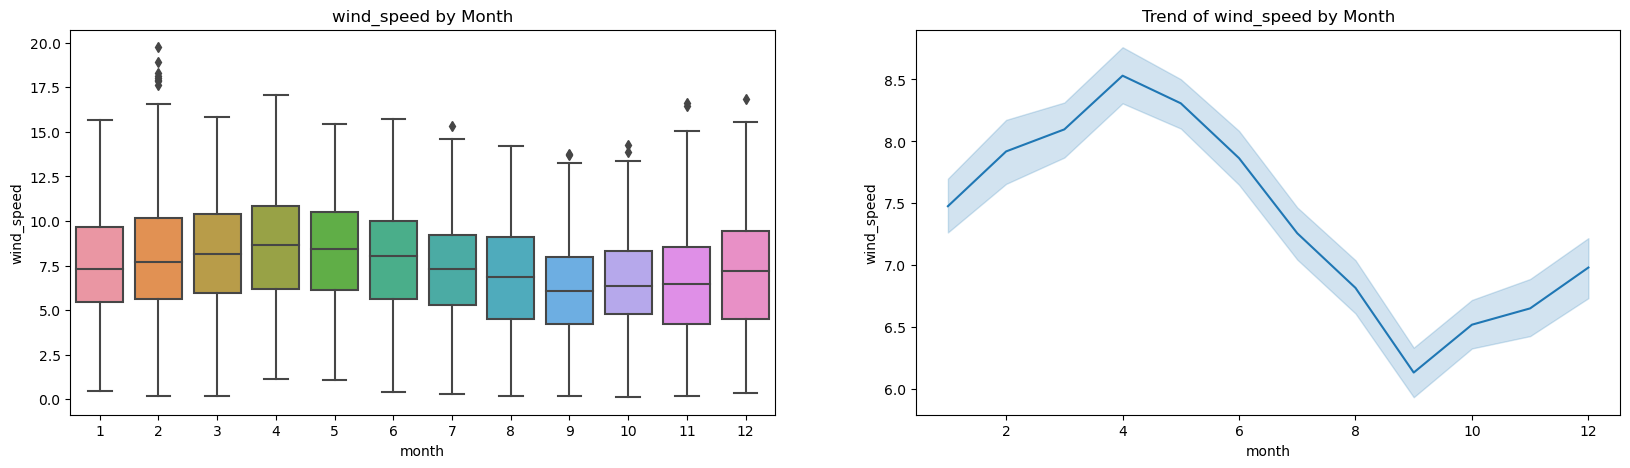

In [42]:
# month and wind_speed
fig, ax = plt.subplots(1,2, figsize = (20,5))

sns.boxplot(x = 'month', y = 'wind_speed', data = df, ax = ax[0])
ax[0].set_title('wind_speed by Month')

sns.lineplot(x = 'month', y = 'wind_speed', data = df, ax = ax[1])
ax[1].set_title('Trend of wind_speed by Month');

##### **Observations**
- Same observation as the power generated vs month

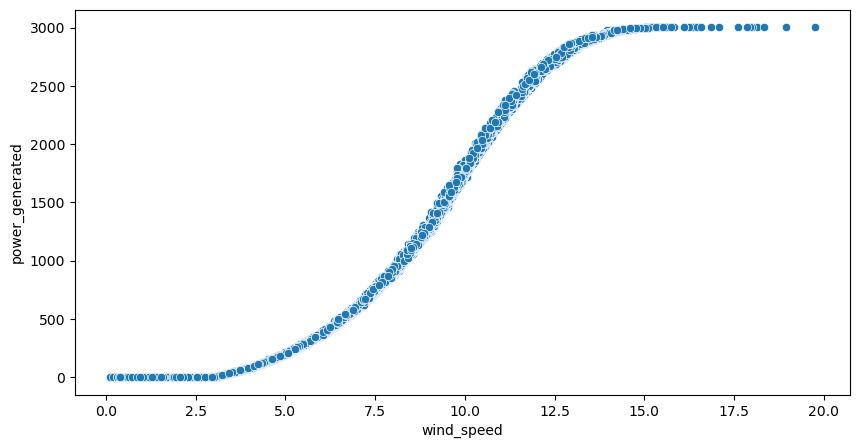

In [43]:
plt.figure(figsize=(10,5))
sns.scatterplot(x = 'wind_speed', y = 'power_generated', data = df);

##### **Observations**
- Wind speed less than 2.5 doesn't generate any power but Wind speed 15.0 and above leads to maximum power generation

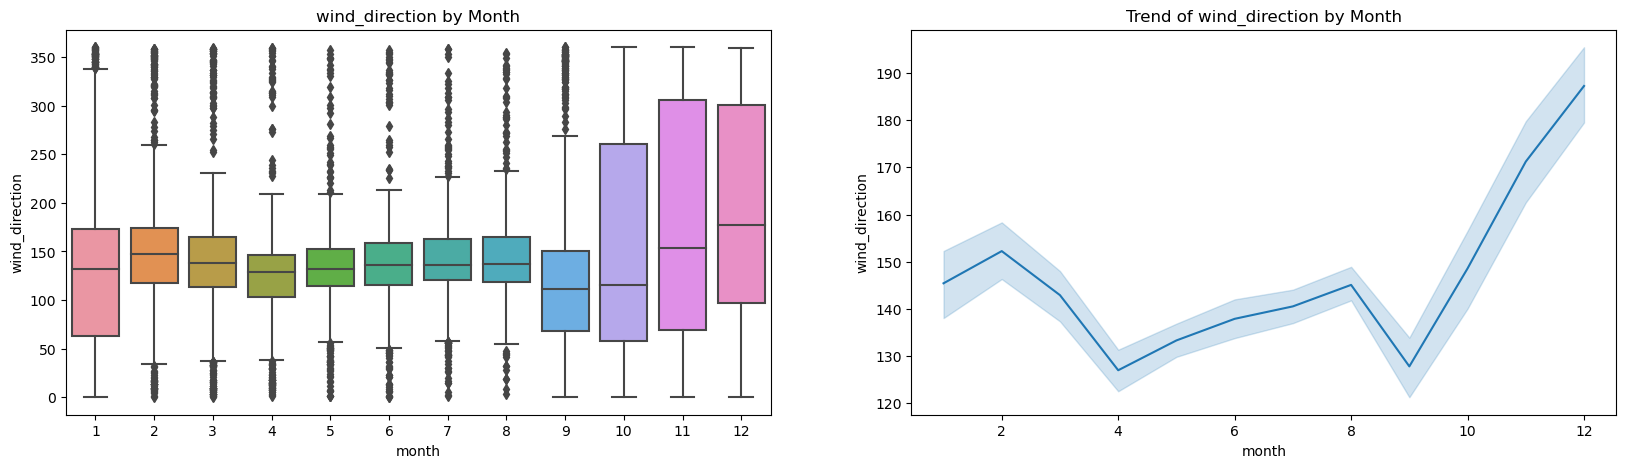

In [44]:
# month and wind_direction
fig, ax = plt.subplots(1,2, figsize = (20,5))

sns.boxplot(x = 'month', y = 'wind_direction', data = df, ax = ax[0])
ax[0].set_title('wind_direction by Month')

sns.lineplot(x = 'month', y = 'wind_direction', data = df, ax = ax[1])
ax[1].set_title('Trend of wind_direction by Month');

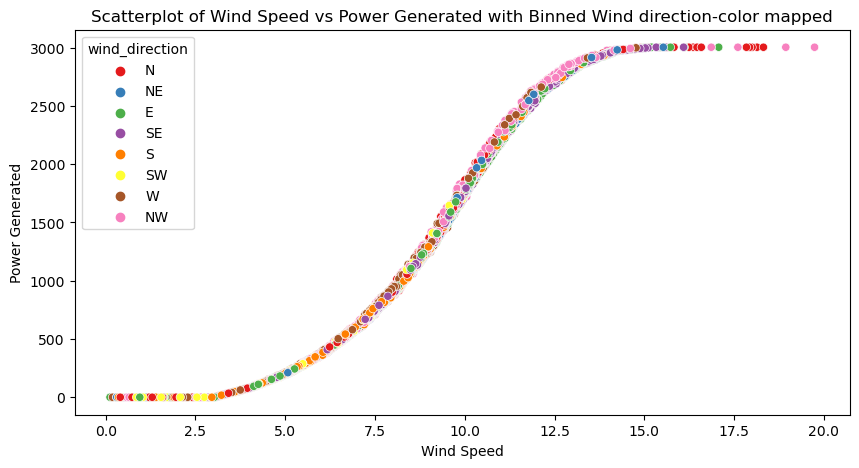

In [45]:
# wind direction - Create a bin to convert the degrees in wind direction to N,S,E,W

bin_labels = ['N','NE','E','SE','S','SW','W','NW']
bin_edges = [-1, 45, 90, 135, 180, 225, 270, 315, 360]
binned_data = pd.cut(df['wind_direction'], bins = bin_edges, labels = bin_labels)

# visualization
plt.figure(figsize=(10,5))
sns.scatterplot(x = 'wind_speed', y = 'power_generated', data = df, hue = binned_data, palette = 'Set1')

plt.title('Scatterplot of Wind Speed vs Power Generated with Binned Wind direction-color mapped')
plt.xlabel('Wind Speed')
plt.ylabel('Power Generated')

plt.show()

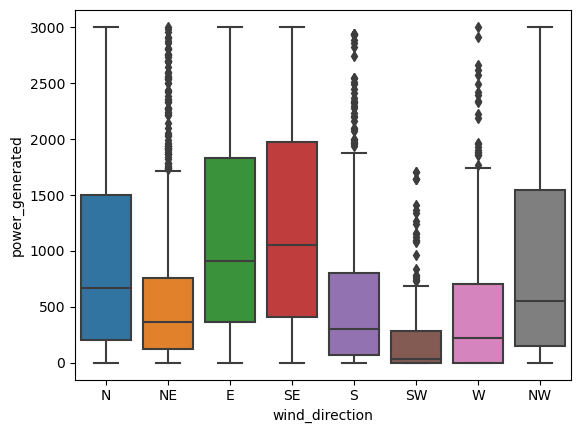

In [46]:
# To properly  see the difference in power generation  values according to wind direction
sns.boxplot(y = df['power_generated'], x = binned_data);

##### **Observations**
- wind direction also influences power generated values

In [47]:
# Add wind_orientation feature to the dataset
df['wind_orientation'] = binned_data

In [48]:
df.head()

,power_generated,wind_speed,wind_direction,pressure,temperature,year,month,quarter,week,day,hour,Season,wind_orientation
Time stamp,,,,,,,,,,,,,
2021-01-01 00:00:00,1766.64,9.926,128,1.000480,18.263,2021,1,1,53,1,0,winter,E
2021-01-01 01:00:00,1433.83,9.273,135,0.999790,18.363,2021,1,1,53,1,1,winter,E
2021-01-01 02:00:00,1167.23,8.660,142,0.999592,18.663,2021,1,1,53,1,2,winter,SE
2021-01-01 03:00:00,1524.59,9.461,148,0.998309,18.763,2021,1,1,53,1,3,winter,SE
2021-01-01 04:00:00,1384.28,9.184,150,0.998507,18.963,2021,1,1,53,1,4,winter,SE


### Mean Encoding & Modelling

In [49]:
# Checking the last so% of the data set

len(df)*0.3

2628.0

In [50]:
# Taking the last 30% of the dataset for testing and the first 70% for training
train_data = df[:-2628]
test_data = df[-2628:]

In [51]:
#train_data

In [52]:
#test_data

In [53]:
# Encoding - using MEAN ENCODING

# mean encoding for Season on the train_data
season_mean = train_data.groupby('Season')['power_generated'].mean()
#add the encoded season to the dataset
df['season_mean_encoded'] = df['Season'].map(season_mean)     

# mean encoding for wind_orientation on the train_data
wind_orien_mean = train_data.groupby('wind_orientation')['power_generated'].mean()
#add the encoded wind_orientation to the dataset
df['wind_orien_mean_encoded'] = df['wind_orientation'].map(wind_orien_mean)

In [54]:
#df.head()

In [55]:
# Drop the Season and wind_orientation column 
df.drop(['Season', 'wind_orientation'], axis = 1, inplace = True)

In [56]:
# Taking the last 30% of the dataset for testing and the first 70% for training after mean encoding
train_data = df[:-2628]
test_data = df[-2628:]

In [57]:
#train_data.head()

In [58]:
#test_data.head()

##### Modeling

- Linear models: Linear regression
- support vector machines: svr
- ensemble: rfr, gbr 


In [59]:
#machine learning algorithms
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [60]:
# selecting x and y train test values
# splitting your feature column and target column

target = 'power_generated'
features = ['wind_speed', 'wind_direction', 'pressure',
           'temperature', 'year', 'month', 'quarter', 'week', 'day', 'hour',
           'season_mean_encoded', 'wind_orien_mean_encoded']

# Training the Data
X_train = train_data[features]
y_train = train_data[target]

# Testing the Data
X_test = test_data[features]
y_test = test_data[target]

In [61]:
# fitting models on train dataset

#linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

#Random forest regressor
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

#support vector machine
sv_model = SVR()
sv_model.fit(X_train, y_train)

#gradient boosting regressor
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

GradientBoostingRegressor()

In [62]:
# making predictions with the trained models
lr_pred = lr_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
sv_pred = sv_model.predict(X_test)
gb_pred = gb_model.predict(X_test)

In [63]:
# Evaluating the test data predicted using MSE
lr_mse = mean_squared_error(y_test, lr_pred)
rf_mse = mean_squared_error(y_test, rf_pred)
sv_mse = mean_squared_error(y_test, sv_pred)
gb_mse = mean_squared_error(y_test, gb_pred)

In [64]:
#printout the evaluation
print('Linear Regression:', lr_mse)
print('Random Forest:', rf_mse)
print('SVM:', sv_mse)
print('Gradient Boosting:', gb_mse)

Linear Regression: 80974.26046757582
Random Forest: 139.63574314320056
SVM: 620189.2321638156
Gradient Boosting: 69.92874839516966


In [65]:
# Evaluating the test data predicted using MAE
lr_mae = mean_absolute_error(y_test, lr_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
sv_mae = mean_absolute_error(y_test, sv_pred)
gb_mae = mean_absolute_error(y_test, gb_pred)

In [66]:
print('Linear Regression:', lr_mae)
print('Random Forest:', rf_mae)
print('SVM:', sv_mae)
print('Gradient Boosting:', gb_mae)

Linear Regression: 228.5804858919763
Random Forest: 5.522303943500742
SVM: 639.9414837806441
Gradient Boosting: 5.725199122200309


In [67]:
y_test.mean()

739.5319913727169

In [83]:
# rf was off by 0.0 percent
5/739 * 100

0.6765899864682002

### Hyperparameter Tuning using Hyperopt and Bayesian Optimization

Hyperparameter Tuning is acrucial step in Optimizing machine learning models. Hyperopt is a python library that provides a convinient way to perform Hyperparameter Tuning using Bayesian Optimization techniques. Bayesian Optimization is a probabilistic model-based optimization model that can effectively search the hyperparameter space to find the optimal set of hyperparameters for a given machine learning models

##### space/set of hyperparameters ==> Optimal values for each hyperparameter

##### Inorder to validate our dataset, we can further split the train dataset into training and validation dataset

In [69]:
# Inorder to validate our dataset, we can further split the train dataset into training and validation dataset

#last 1200 dataset for train
X_train = X_train[:-1200]
y_train = y_train[:-1200]

# everything else for validation
X_val = X_train[-1200:]
y_val = y_train[-1200:]

In [70]:
len(X_train)

4932

In [71]:
len(X_val)

1200

In [72]:
# hyperparameter optimization for random forest
import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# create a space
space = {
            'n_estimators': hp.quniform('n_estimators', 100, 300, 1),
            'max_depth': hp.quniform('max_depth', 5, 20, 1),
            'max_features': hp.choice('max_features', ['sqrt', 'log2', None])
        }

# objective > sample fro the space, craete a radomforest model, evaluate the model, loss/mse
def objective(params):
    n_estimators = int(params['n_estimators'])
    max_depth = int(params['max_depth'])
    max_features = params['max_features']
    
    hyper_rf_model = RandomForestRegressor(
                                    n_estimators = n_estimators,
                                    max_depth = max_depth,
                                    max_features = max_features,
                                    random_state = 42
    )

    # evaluate the model and return the loss/mse
    hyper_rf_model.fit(X_train, y_train)
    pred = hyper_rf_model.predict(X_val)
    
    mse = mean_squared_error(y_val, pred)
    
    return {'loss': mse, 'status': STATUS_OK}
    
# minimize the objective ==> fmin
trials = Trials()

best = fmin(
            fn = objective,
            space = space,
            algo = tpe.suggest,
            max_evals = 100,
            trials = trials,
            verbose = 1
            )

print('Best Hyperparameters:', best)

100%|████████████████████████████████████████████████| 100/100 [10:18<00:00,  6.18s/trial, best loss: 2.67354572559734]
Best Hyperparameters: {'max_depth': 15.0, 'max_features': 2, 'n_estimators': 227.0}


In [73]:
best_rf_hyperparameters = {'max_depth': 15.0, 'max_features': 2, 'n_estimators': 227.0}

In [74]:
# hyperparameter optimization for gradient boosting
import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# create a space
space = {
            'n_estimators': hp.quniform('n_estimators', 100, 300, 1),
            'max_depth': hp.quniform('max_depth', 5, 20, 1),
            'learning_rate': hp.loguniform('learning_rate', -5, 0),
            'subsample': hp.uniform('subsample', 0.1, 1.0)
        }

# objective > sample fro the space, craete a radomforest model, evaluate the model, loss/mse
def objective(params):
    n_estimators = int(params['n_estimators'])
    max_depth = int(params['max_depth'])
    
    
    hyper_gb_model = GradientBoostingRegressor(
                                    n_estimators = n_estimators,
                                    max_depth = max_depth,
                                    learning_rate = params['learning_rate'],
                                    subsample = params['subsample'],
                                    random_state = 42
    )

    hyper_gb_model.fit(X_train, y_train)
    pred = hyper_gb_model.predict(X_val)
    
    mse = mean_squared_error(y_val, pred)
    
    return {'loss': mse, 'status': STATUS_OK}
    
# minimize the objective ==> fmin
trials = Trials()

best = fmin(
            fn = objective,
            space = space,
            algo = tpe.suggest,
            max_evals = 100,
            trials = trials,
            verbose = 1
            )

print('Best Hyperparameters:', best)

100%|██████████████████████████████████████████| 100/100 [10:35<00:00,  6.35s/trial, best loss: 1.8079254603514142e-16]
Best Hyperparameters: {'learning_rate': 0.9145594198427156, 'max_depth': 18.0, 'n_estimators': 299.0, 'subsample': 0.6531371369440083}


In [75]:
best_gb_hyperparameters = {'learning_rate': 0.9145594198427156, 'max_depth': 18.0, 'n_estimators': 299.0, 'subsample': 0.6531371369440083}

##### Using the best hyoerparameters, train the whole dataset on them

In [76]:
# Taking the last 30% of the dataset for testing and the first 70% for training
train_data = df[:-2628]
test_data = df[-2628:]

In [77]:
# splitting your feature column and target column
target = 'power_generated'
features = ['wind_speed', 'wind_direction', 'pressure',
           'temperature', 'year', 'month', 'quarter', 'week', 'day', 'hour',
           'season_mean_encoded', 'wind_orien_mean_encoded']

# Training the Data
X_train = train_data[features]
y_train = train_data[target]

# Testing the Data
X_test = test_data[features]
y_test = test_data[target]

In [78]:

best_rf_hyperparameters

{'max_depth': 15.0, 'max_features': 2, 'n_estimators': 227.0}

In [80]:
# Hyperparameter optimization for random forest
hyper_rf_model = RandomForestRegressor(
                                    n_estimators = 227,
                                    max_depth = 15,
                                    max_features = 2,
                                    random_state = 42)

hyper_rf_model.fit(X_train, y_train)
rf_pred = hyper_rf_model.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)

print('MSE:', rf_mse, 'MAE:', rf_mae)

MSE: 93604.12939429896 MAE: 217.5858275115339


In [81]:
best_gb_hyperparameters

{'learning_rate': 0.9145594198427156,
 'max_depth': 18.0,
 'n_estimators': 299.0,
 'subsample': 0.6531371369440083}

In [82]:
# Hyperparameter optimization for gradient boosting
hyper_gb_model = GradientBoostingRegressor(
                                    n_estimators = 299,
                                    max_depth = 18,
                                    learning_rate = best_gb_hyperparameters['learning_rate'],
                                    subsample = best_gb_hyperparameters['subsample'],
                                    random_state = 42)

hyper_gb_model.fit(X_train, y_train)
gb_pred = hyper_gb_model.predict(X_test)

gb_mse = mean_squared_error(y_test, gb_pred)
gb_mae = mean_absolute_error(y_test, gb_pred)

print('MSE:', gb_mse, 'MAE:', gb_mae)

MSE: 444.6271308479058 MAE: 13.036296915079129


##### **Observation**
- Hyperparameter optimization for both random forest and gradient boosting result into higher MSE & MAE, this might be due to overfitting.

##### **Observation** - Best Performing Model
Best Performing Models are **Gradient Boosting Regressor default / Random forest default**. 
- For our **inference script for deployment,** we are going for **Gradient boosting regressor** because of it **smaller MSE of 69 to randon forest 139 and both have MAE of 5**.

### Inference Script Creation

In [295]:
df = pd.read_csv(r"C:\Users\Abdulwahab\Desktop\Amdari Projects\2. Renewable Energy Forecasting with Pandas and Machie Learning\TexasTurbine.csv")

features = df.sample(5)

# rename the dataset columns
features.columns = ['Time stamp', 'power_generated', 'wind_speed','wind_direction', 'pressure',
               'temperature']

# separate the target column (power_generated) from the dataset
target = features['power_generated']

# Drop the target column from the dataset
features.drop('power_generated', axis = 1, inplace = True)

In [296]:
features

,Time stamp,wind_speed,wind_direction,pressure,temperature
2444,"Apr 12, 08:00 pm",4.953,81,1.001170,19.263
6422,"Sep 25, 02:00 pm",2.145,92,0.988136,24.963
3569,"May 29, 05:00 pm",9.787,100,0.989224,22.663
2047,"Mar 27, 07:00 am",3.925,154,0.985772,19.863
6085,"Sep 11, 01:00 pm",6.070,112,0.988627,30.063


In [297]:
target

2444     195.1670
6422       0.0000
3569    1654.0500
2047      72.3359
6085     366.8280
Name: power_generated, dtype: float64

In [281]:
def fix_timestamp(df):
    '''
    this function converts date time column to a proper format and set it as the index 
    '''
    
    # Fix the timestamp to it correct datatype
    df['Time stamp'] = pd.to_datetime(df["Time stamp"], format = '%b %d, %I:%M %p').dt.strftime('%Y-%m-%d %H:%M:%S')

    # Replace the !900 with 2021
    df['Time stamp'] = df['Time stamp'].str.replace('1900', '2021')

    # Convert the timestamp to it correct datatype
    df['Time stamp'] = pd.to_datetime(df["Time stamp"])
    
    # Set the timestamp as index
    df.index = df['Time stamp']

    # Drop the time stamp column to avoid duplicate column of the time stamp since we already made it our index
    df.drop('Time stamp', axis = 1, inplace = True)
    
    return df

In [282]:
features = fix_timestamp(features)

In [283]:
#features

In [284]:
features = extract_features(features)
features['Season'] = features['month'].apply(group_month_into_season)

In [285]:
#features

In [286]:
# wind direction - Create a bin to convert the degrees in wind direction to N,S,E,W
def bin_wind_dir(df):
    '''this function takes in data, convert the wind directions from degrees to cardinal points'''
    
    bin_labels = ['N','NE','E','SE','S','SW','W','NW']
    bin_edges = [-1, 45, 90, 135, 180, 225, 270, 315, 360]
    binned_data = pd.cut(df['wind_direction'], bins = bin_edges, labels = bin_labels)
    # Add wind_orientation feature to the dataset
    df['wind_orientation'] = binned_data
    
    return df

In [287]:
# preview the dataset including bin_wind_dir column
features = bin_wind_dir(features)

In [288]:
# function for mean encoding of season and wind orientation
def mean_encode(df, season_mean = season_mean, wind_orien_mean = wind_orien_mean):
    
    df['season_mean_encoded'] = df['Season'].map(season_mean)     
    df['wind_orien_mean_encoded'] = df['wind_orientation'].map(wind_orien_mean)
    
    df.drop(['Season', 'wind_orientation'], axis = 1, inplace = True)
    
    return df

In [289]:
# preview the dataset including season_mean_encoded column & wind_orien_mean_encoded
features = mean_encode(features)

In [290]:
features

,wind_speed,wind_direction,pressure,temperature,year,month,quarter,week,day,hour,season_mean_encoded,wind_orien_mean_encoded
Time stamp,,,,,,,,,,,,
2021-11-01 02:00:00,8.186,202,0.986262,24.263,2021,11,4,44,1,2,867.021622,528.993476
2021-10-15 19:00:00,11.053,127,0.988630,26.163,2021,10,4,41,15,19,867.021622,1214.650349
2021-09-19 20:00:00,7.177,74,0.992578,25.263,2021,9,3,37,19,20,867.021622,597.096607
2021-01-20 20:00:00,6.762,57,0.999300,14.263,2021,1,1,3,20,20,1058.753692,597.096607
2021-08-21 09:00:00,1.127,209,0.993069,29.263,2021,8,3,33,21,9,927.663718,528.993476


In [291]:
gb_model.predict(features)

array([ 9.64349029e+02,  2.20415621e+03,  6.44278959e+02,  5.60461134e+02,
       -6.40840268e-01])

In [292]:
target

7298     950.326
6907    2213.320
6284     634.840
476      555.993
5577       0.000
Name: power_generated, dtype: float64

In [293]:
# create the inference function
def inference(features, model = gb_model):                     
    features = fix_timestamp(features)
    features = extract_features(features)
    features['Season'] = features['month'].apply(group_month_into_season)
    features = bin_wind_dir(features)
    features = mean_encode(features)
    predictions = model.predict(features)               ##'''this function(model) has the ability to receive any kind of 
                                                        ## model as argument. Gradientbosting is our default model we created'''
    return predictions

In [298]:
inference(features)

array([1.89651765e+02, 6.84515797e-01, 1.64841262e+03, 7.07032362e+01,
       3.70021890e+02])

#### To stimulate an output/inference for an hour

In [348]:
df = pd.read_csv(r"C:\Users\Abdulwahab\Desktop\Amdari Projects\2. Renewable Energy Forecasting with Pandas and Machie Learning\TexasTurbine.csv")

features = df.sample(1)

# rename the dataset columns
features.columns = ['Time stamp', 'power_generated', 'wind_speed','wind_direction', 'pressure',
               'temperature']

# separate the target column (power_generated) from the dataset
target = features['power_generated']

# Drop the target column from the dataset
features.drop('power_generated', axis = 1, inplace = True)

In [349]:
features

,Time stamp,wind_speed,wind_direction,pressure,temperature
1086,"Feb 15, 06:00 am",8.68,155,0.997422,17.413


In [350]:
inference(features)

array([1178.24656722])

In [351]:
# to confirm the closeness of the infernce and target 
target

1086    1177.31
Name: power_generated, dtype: float64